### Анализ и прогнозирование временного ряда.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Читаем данные

In [2]:
df = pd.read_excel('data/Lake.xls', index_col='Дата')
df.head()

,Станция,"Глубина станции, м","Прозр,м","Горизонт, м","Температура, оС","Раств кислород, мг/л",% насыщения
Дата,,,,,,,
1955-08-02,Станция-2,5.0,NaN,0.05,23.65,10.06,119.9
1955-08-02,Станция-2,5.0,NaN,3.00,19.00,5.27,57.2
1955-08-02,Станция-2,5.0,NaN,4.50,NaN,5.13,NaN
1955-08-18,Станция-2,5.5,NaN,0.05,22.30,9.96,115.5
1955-08-18,Станция-2,5.5,NaN,2.00,22.00,9.99,115.2


Будем исследовать растворимость кислорода на горизонте 3м за август месяц. Если за месяц имеется несколько наблюдений, возьмем среднее значение.

In [3]:
# Горизонт 3м и август месяц наблюдений растворимости кислорода
df = df[ (df['Горизонт, м'] == 3) & (df.index.month == 8) ]['Раств кислород, мг/л']

In [4]:
# df.resample(rule='AS-AUG').mean()

Будем исследовать наблюдения начиная с 1966 года. Пропущенные значения заполним средним арифметическим предыдущим и следующим значениями.

In [5]:
df = df.resample(rule='AS-AUG').mean()['1966-08-01':]

In [6]:
df.index.rename('Data', inplace=True);
df.rename('Oxygen', inplace=True);

In [7]:
for i in range(len(df)):
    if np.isnan(df.iloc[i]):
        df.iloc[i] = (df.iloc[i-1] + df.iloc[i+1]) / 2

In [8]:
# df.head()

#### График временного ряда

In [9]:
def plot_attributes(ax, xlabel='', ylable='', title=''):
    ax.set_xlabel(xlabel, size = 15, weight='bold')
    ax.set_ylabel(ylable, size = 15, weight='bold')
    ax.set_title(title, size = 10, weight='bold')
    return ax

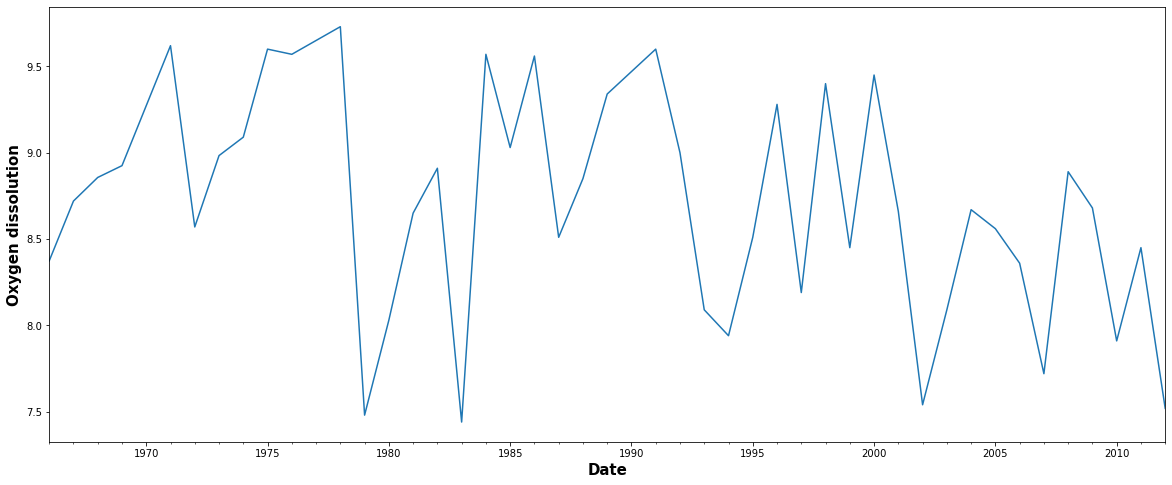

In [10]:
ax = df.plot(figsize=(20, 8));
plot_attributes(ax, 'Date', 'Oxygen dissolution');

#### Анализ графика
- Так как мы используем наблюдения за август месяц с 1966 по 2012 года, то будем считать, что сезонность отсуствует.
- Со временем значения наблюдений падают, что может свидетельствовать о наличии снисходящего тренда, однако явно распознать его нельзя.
- Аномальные значения наблюдения при первом взгляде на график отсуствуют.

#### Описательные характеристики

In [11]:
def describe(series):
    return pd.DataFrame(
        index=['observations','min-max','mean','variance','skewness','kurtosis'], 
        data=stats.describe(series), 
        columns=['satatistics'])

describe(df)

,satatistics
observations,47
min-max,"(7.44, 9.73)"
mean,8.73957
variance,0.431117
skewness,-0.316759
kurtosis,-0.825824


- **Средняя растворимость кислорода**у озера Баторино в период с 1966 по 2012 год равна **8.74%.**

- **Коэффициент асимметрии** равен **-0.31**, что означает, что асимметрия умеренная. У нормального распределения коэффициент равен 0, следовательно, распределение несимметрично и немного скошено влево.

- **Коэффициент эксцесса** равен **-0.83**. У нормального распределения он имеет значение равное 0, из этого следует, что у нас пологий пик распределения по отношению к нормальному.

In [12]:
from scipy.stats import shapiro, kstest
from statsmodels.graphics.gofplots import qqplot

def shapiro_test(series):
    stat, p_val = shapiro(series)
    print('Shapiro-Wilk test:')
    print(f'p_value: {p_val}, statistics: {stat}')
    if(p_val > 0.05):
        print(f'assume a normal distribution')
    else:
        print(f'not assume a normal distribution')
        
def ks_test(series):
    stat, p_val = kstest(series, 'norm')
    print('Kolmogorov Smirnov test:')
    print(f'p_value: {p_val}, statistics: {stat}')
    if(p_val > 0.05):
        print(f'assume a normal distribution')
    else:
        print(f'not assume a normal distribution')
        
def check_normal(series):
    #Shapiro-Wilk test
    shapiro_test(series)
    
    print()
    
    #Kolmogorov Smirnov test:
    ks_test(series)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    
    #Histogram. Number of Bins is calculated by Sturges rule: bins= 1 + log2[N], N - size of series
    bins = int(3 + np.log2(series.size))
    series.plot.hist(bins=bins, edgecolor='k', density=True, ax=ax1)
    s_min, s_max = np.min(series), np.max(series)
    s_mean, s_var = np.mean(series), np.var(series)
    
    mas = np.linspace(s_min, s_max, 100);
    ax1.plot(mas, stats.norm.pdf(mas,loc=s_mean,scale=s_var), color='k');
    plot_attributes(ax1, 'Oxygen dissolution', '', 'Histogram');
    
    #QQ plot
    stats.probplot(series, plot=ax2)
    plot_attributes(ax2, 'Normal theoretical quantiles', 'Oxygen dissolution quantiles', 'QQ-plot');
    

#### Проверка на нормальное распределение

Shapiro-Wilk test:
p_value: 0.04968912899494171, statistics: 0.9515230655670166
not assume a normal distribution

Kolmogorov Smirnov test:
p_value: 0.0, statistics: 0.9999999999999497
not assume a normal distribution


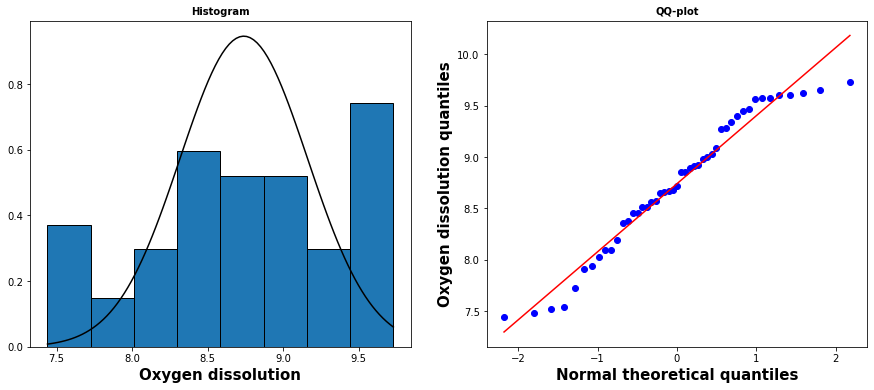

In [13]:
check_normal(df)

- Тест Шапиро-Уилка: p_value = 0.049 < 0.05, следовательно, гипотеза о нормальном рпспределении отвергается.
- Тест Колмагорова-Смирнова: p_value = 0.00 < 0.05, следовательно, гипотеза о нормальном рпспределении отвергается.
- Гистограмма скошена влево и имеет пологий пик. Данные не очень хорошо ложаться под график плотности нормального распределения.
- Точки на квантиль-квантиль графике выстраиваются в прямую линию, однако на концах присутсвуют отклонения.

**Вывод: исходный ряд не подчиняется закону нормального распределения**

In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

#### Проверка на стационраность

In [15]:
adf_test(df)

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.013826
p-value                  0.000021
# lags used              0.000000
# observations          46.000000
critical value (1%)     -3.581258
critical value (5%)     -2.926785
critical value (10%)    -2.601541
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Тест Дики-Фуллера: p_value < 0.05, следовательно гипотеза о наличии единиченого корня отвергается и предполагаем, что наш ряд стационарный.

#### Автокорреляция

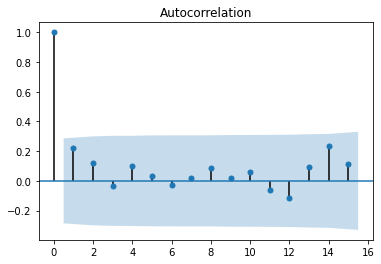

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df, lags=15);
#plot_pacf(df);

График автокорреляции выглядит как график стационарного ряда. Ряд является стационарным.

Разобьем нашу выборку на две части, обучающую и тестовую.

In [17]:
train = df.iloc[:40]
test = df.iloc[40:]

Построим модель с помощью экспоненциального сглаживания. Так как у нас отсуствуют тренд и сезонность, применим экспоненциальное сглаживание первого порядка.

In [18]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

SES_model = SimpleExpSmoothing(train)
SES_fitted = SES_model.fit(smoothing_level=0.6)

In [19]:
SES_results = SES_fitted.predict(len(train), len(df)).rename('SES(alpha=0.6)')
SES_fitted.summary()

Dep. Variable:,endog,No. Observations:,40
Model:,SimpleExpSmoothing,SSE,20.211
Optimized:,True,AIC,-23.307
Trend:,None,BIC,-19.929
Seasonal:,None,AICC,-22.164
Seasonal Periods:,None,Date:,"Sun, 07 Feb 2021"
Box-Cox:,False,Time:,01:42:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6000000,alpha,False
initial_level,8.5472630,l.0,True


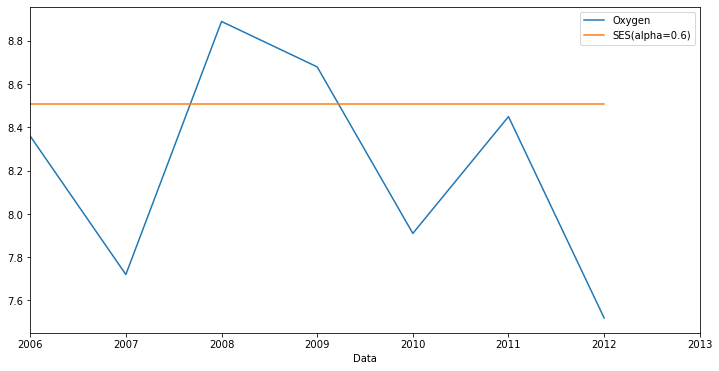

In [20]:
test.plot(figsize=(12,6), legend=True);
SES_results.shift(-1).plot(legend=True);

In [21]:
from pmdarima import auto_arima

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

In [23]:
sarimax_model = SARIMAX(train)

In [24]:
sarimax_fit = sarimax_model.fit()

In [25]:
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Oxygen   No. Observations:                   40
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -50.747
Date:                Sun, 07 Feb 2021   AIC                            105.494
Time:                        01:42:29   BIC                            108.872
Sample:                    08-01-1966   HQIC                           106.715
                         - 08-01-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9955      0.015     65.514      0.000       0.966       1.025
sigma2         0.6583      0.134      4.909      0.000       0.395       0.921
===================================================================================
Ljung-Box (Q):                       37.76   Jarque-Bera (JB):                 2.01
Prob(Q):                              0.53   Prob(JB):                         0.37
Heteroskedasticity (H):               3.26   Skew:                            -0.43
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
sarimax_results = sarimax_fit.predict(len(train), len(df)).shift(-1).rename('sarimax(1,0,0)')

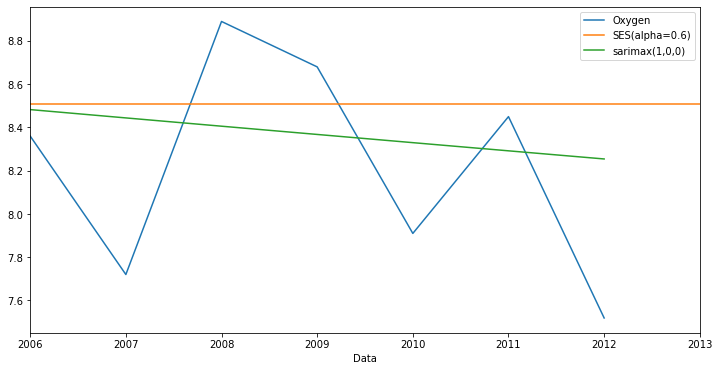

In [27]:
test.plot(figsize=(12,6), legend=True);
SES_results.plot(legend=True);
sarimax_results.plot(legend=True);